Enron data project - Alex Challenor

Project Overview

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. In the resulting Federal investigation, a significant amount of typically confidential information entered into the public record, including tens of thousands of emails and detailed financial data for top executives. 

In this project i will use the provided data to:

- Select features to use
- Make features
- Find and deal with outliers
- Test diffrent classifers
- Tune classifer to find best paramebter

From this my Clasifier and paramter could be used to go through the thausands of files to help find People of Intrest (POI).


In [2]:
# Import required modules
import sys
import pickle
import pandas as pd
import numpy as np
from time import time
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import test_classifier, dump_classifier_and_data
from sklearn.feature_selection import SelectKBest,f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from collections import OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\ProgramData\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
# Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

In [4]:
# Load the dictionary into a dataframe and examine it
dataset_df=pd.DataFrame.from_dict(data_dict,orient='index')

In [5]:
dataset_df.head()

,salary,to_messages,deferral_payments,total_payments,exercised_stock_options,bonus,restricted_stock,shared_receipt_with_poi,restricted_stock_deferred,total_stock_value,...,loan_advances,from_messages,other,from_this_person_to_poi,poi,director_fees,deferred_income,long_term_incentive,email_address,from_poi_to_this_person
ALLEN PHILLIP K,201955,2902,2869717,4484442,1729541,4175000,126027,1407,-126027,1729541,...,NaN,2195,152,65,False,NaN,-3081055,304805,phillip.allen@enron.com,47
BADUM JAMES P,NaN,NaN,178980,182466,257817,NaN,NaN,NaN,NaN,257817,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN
BANNANTINE JAMES M,477,566,NaN,916197,4046157,NaN,1757552,465,-560222,5243487,...,NaN,29,864523,0,False,NaN,-5104,NaN,james.bannantine@enron.com,39
BAXTER JOHN C,267102,NaN,1295738,5634343,6680544,1200000,3942714,NaN,NaN,10623258,...,NaN,NaN,2660303,NaN,False,NaN,-1386055,1586055,NaN,NaN
BAY FRANKLIN R,239671,NaN,260455,827696,NaN,400000,145796,NaN,-82782,63014,...,NaN,NaN,69,NaN,False,NaN,-201641,NaN,frank.bay@enron.com,NaN


In [6]:
# Replace 'NaN' string with Null (NaN)
dataset_df.replace('NaN',np.nan,inplace=True)


In [7]:
# Dataset details
num_employees=len(dataset_df)
num_poi=len(dataset_df[dataset_df['poi']==True])
num_non_poi=num_employees-num_poi
num_vals=num_employees-dataset_df.isnull().sum()

Visulise the current features and remove features with little data,

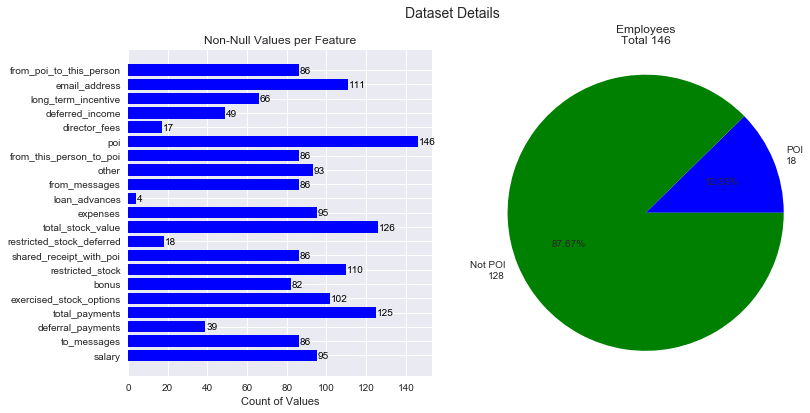

In [8]:
# Plot POI and feature count
plt.figure(figsize=(12,6))
plt.suptitle('Dataset Details',fontsize=14)
# Left plot
plt.subplot(1,2,1)
plt.barh(range(len(num_vals.index)),num_vals,height=-0.8,color=['blue'])
plt.yticks(range(len(num_vals.index)),num_vals.index)
for i,v in enumerate(num_vals):
 plt.text(v+0.4,i-0.2,str(v),color='black')
 plt.title('Non-Null Values per Feature')
plt.xlabel('Count of Values')
# Right plot
plt.subplot(1,2,2)
plt.title('Employees\nTotal '+str(num_employees))
plt.pie([num_poi,num_non_poi],labels=['POI\n'+str(num_poi),'Not POI\n'+str(num_non_poi)],
 autopct='%.2f%%',colors=['blue','green'])
plt.axis('equal')
plt.show()


In [11]:
# Which features have less than 10% data
df=dataset_df.count()/len(dataset_df)<0.1
list(df[df==True].index)

['loan_advances']

In [12]:
# Which features have less than 10% data for POI
df=dataset_df[dataset_df['poi']==True].count()/dataset_df.count()<0.1
list(df[df==True].index)


['restricted_stock_deferred', 'director_fees']

In [13]:
# Selected features
POI_label=['poi'] # Boolean, represented as integer
financial_features=['salary','deferral_payments','total_payments','bonus','deferred_income',
 'total_stock_value','expenses','exercised_stock_options','other',
 'long_term_incentive','restricted_stock'] # Units are in US dollars
email_features=['to_messages','from_poi_to_this_person','from_messages',
 'from_this_person_to_poi','shared_receipt_with_poi'] # Units are number of
# We will ignore:
# 'email_address' - not numerical data
# 'restricted_stock_deferred' and 'director_fees' - less than 10% data for POI
# 'loan_advances' - less than 10% data
features_list=(POI_label+financial_features+email_features)
print 'Number of initial features: ',len(features_list)

Number of initial features:  17


Email adress doesnt provide usefull feature so remove

In [15]:
#Drop email address since we are not using it in this analysis
dataset_df.drop('email_address',axis=1,inplace=True)


Remove outliers

Visuliase data to look for data with any obviouse outliers.
Also manualy check data against the enron_insderpay.pdf to see if assumptions line up.

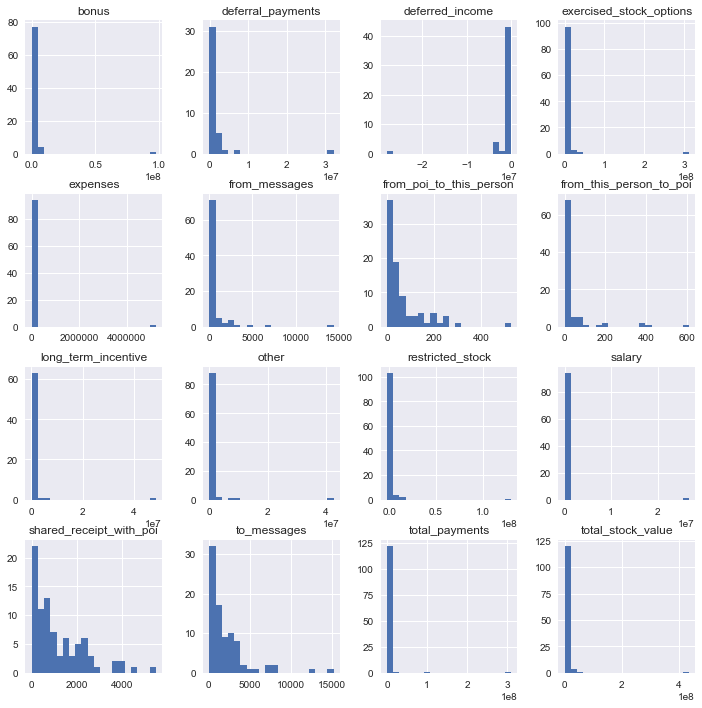

In [17]:
# Visualise data to show any outliers
dataset_df[features_list[1:]].hist(figsize=(12,12),bins=20);

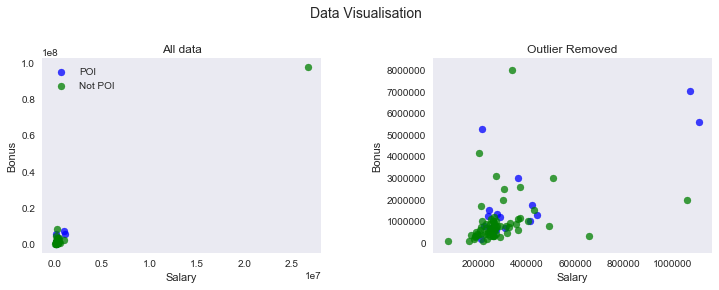

In [18]:
#Plot of data with suspected outlier
plt.figure(figsize=(12,4))
plt.suptitle('Data Visualisation',fontsize=14)
# Left plot
plt.subplot(1,2,1)
x1=dataset_df[dataset_df['poi'] == True]['salary']
y1=dataset_df[dataset_df['poi'] == True]['bonus']
x2=dataset_df[dataset_df['poi'] == False]['salary']
y2=dataset_df[dataset_df['poi'] == False]['bonus']
plt.scatter(x1,y1,color='blue',alpha=0.75)
plt.scatter(x2,y2,color='green',alpha=0.75)
plt.title('All data')
plt.ylabel('Bonus')
plt.xlabel('Salary')
plt.legend(('POI','Not POI'))
plt.grid()
# Right plot
plt.subplot(1,2,2)
outlier=dataset_df['salary'].idxmax()
df=dataset_df[dataset_df.index != outlier]
x1=df[df['poi'] == True]['salary']
y1=df[df['poi'] == True]['bonus']
x2=df[df['poi'] == False]['salary']
y2=df[df['poi'] == False]['bonus']
plt.scatter(x1,y1,color='blue',alpha=0.75)
plt.scatter(x2,y2,color='green',alpha=0.75)
plt.title('Outlier Removed')
plt.ylabel('Bonus')
plt.xlabel('Salary')
plt.subplots_adjust(wspace=0.4,top=0.8)
plt.grid()
plt.show()


In [19]:
# Outlier
print 'Outlier found in row:',outlier

Outlier found in row: TOTAL


looking at the pdf that comes along with the data "the travel agency..." is not a person so should be taken out of data
Eugene Lockhart has no data against hime so i will take this out of the data
From the outlier graphs i will reomve "total" as this a function of the spreadsheet and not usefull data

In [21]:
# Drop the following:
# TOTAL - Spreadsheet aggregation included by mistake (outlier)
# LOCKHART EUGENE E - Does not contain any numerical data
# THE TRAVEL AGENCY IN THE PARK - Not an individual (Alliance Worldwide - co-owned by the s
dataset_df.drop(['TOTAL','LOCKHART EUGENE E','THE TRAVEL AGENCY IN THE PARK'],axis=0,inplace=True)

Now i have investigated the data i will make some more features.

In [23]:
# New financial features:
dataset_df['fraction_bonus_salary']=dataset_df['bonus']/dataset_df['salary']
dataset_df['fraction_bonus_total']=dataset_df['bonus']/dataset_df['total_payments']
dataset_df['fraction_salary_total']=dataset_df['salary']/dataset_df['total_payments']
dataset_df['fraction_stock_total']=dataset_df['total_stock_value']/dataset_df['total_payments']

In [24]:
# New email features:
dataset_df['fraction_to_poi']=dataset_df['from_this_person_to_poi']/dataset_df['from_messages']
dataset_df['fraction_from_poi']=dataset_df['from_poi_to_this_person']/dataset_df['to_messages']

In [25]:
# Add new features to feature list
new_features_list=['fraction_bonus_salary',
 'fraction_bonus_total',
'fraction_salary_total',
'fraction_stock_total',
'fraction_to_poi',
'fraction_from_poi']
extended_features_list=features_list+new_features_list
print 'Number of extended features: ',len(extended_features_list)

Number of extended features:  23


In [26]:
# Cleaned and trimmed dataset
num_employees=len(dataset_df[extended_features_list])
num_poi=len(dataset_df[dataset_df['poi']==True])
num_non_poi=num_employees-num_poi
num_vals=num_employees-dataset_df[extended_features_list].isnull().sum()

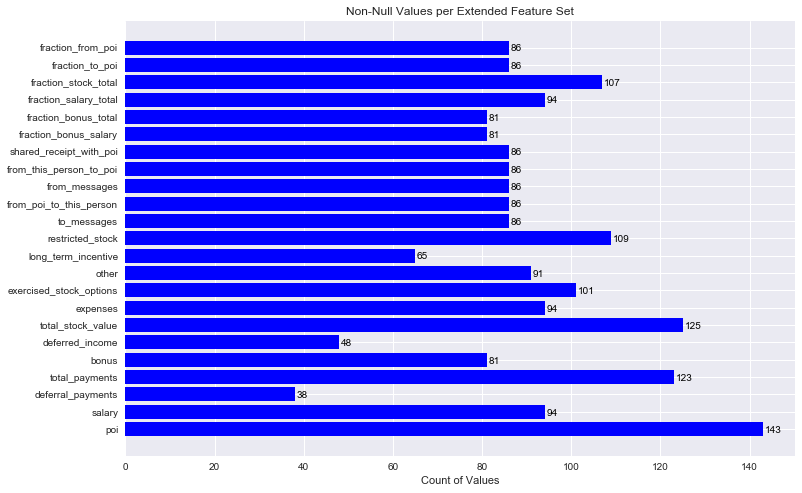

In [27]:
#Plot POI and feature count
plt.figure(figsize=(12,8))
#plt.subplot(1,2,1)
plt.barh(range(len(num_vals.index)),num_vals,height=-0.8,color=['blue'])
plt.yticks(range(len(num_vals.index)),num_vals.index)
for i,v in enumerate(num_vals):
 plt.text(v+0.4,i-0.2,str(v),color='black')
 plt.title('Non-Null Values per Extended Feature Set')
plt.xlabel('Count of Values')
plt.show()


In [28]:
# Replace Null (NaN) entries with 0.0 to prevent errors in algorithms
dataset_df.fillna(value=0.0,inplace=True)

In [29]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 143 entries, ALLEN PHILLIP K to YEAP SOON
Data columns (total 26 columns):
salary                       143 non-null float64
to_messages                  143 non-null float64
deferral_payments            143 non-null float64
total_payments               143 non-null float64
exercised_stock_options      143 non-null float64
bonus                        143 non-null float64
restricted_stock             143 non-null float64
shared_receipt_with_poi      143 non-null float64
restricted_stock_deferred    143 non-null float64
total_stock_value            143 non-null float64
expenses                     143 non-null float64
loan_advances                143 non-null float64
from_messages                143 non-null float64
other                        143 non-null float64
from_this_person_to_poi      143 non-null float64
poi                          143 non-null bool
director_fees                143 non-null float64
deferred_income              143 

In [30]:
### Store to my_dataset for easy export below.
my_dataset=dataset_df.to_dict('index')
### Extract original features and labels from dataset
data=featureFormat(my_dataset,features_list,sort_keys=True)
labels,features=targetFeatureSplit(data)
### Extract extended features and labels from dataset
data=featureFormat(my_dataset,extended_features_list,sort_keys=True)
labels2,features2=targetFeatureSplit(data)

Feature selection

Now i have the orginal features and my new created features i need to decide which feattures are best to use.
To do this i will use SKlearn's Kbeast function.

Doing this will choose the features that should decrease overfitting and improve the accuracy of the alogrythem.

Feature selection is the process by which the machine learning algorithm automatically selects those features
select those features that have the strongest relationship with the target variable. Feature selection can be used
either to improve accuracy scores or to increase performance on high-dimensional data.

 useing SelectKBest to select features according to the k highest scores, according to the f_classif scoring
function which computes the ANOVA F-value for the data. 
In this instance we use k=12


In [32]:
# Select K-Best features
n=12

k_best1=SelectKBest(score_func=f_classif,k=n)
k_best1.fit(features,labels)
feature_scores1=zip(features_list[1:],k_best1.scores_)
k_best_features1=OrderedDict(sorted(feature_scores1,key=lambda x: x[1],reverse=True))

k_best2=SelectKBest(score_func=f_classif,k=n)
k_best2.fit(features2,labels2)
feature_scores2=zip(extended_features_list[1:],k_best2.scores_)
k_best_features2=OrderedDict(sorted(feature_scores2,key=lambda x: x[1],reverse=True))

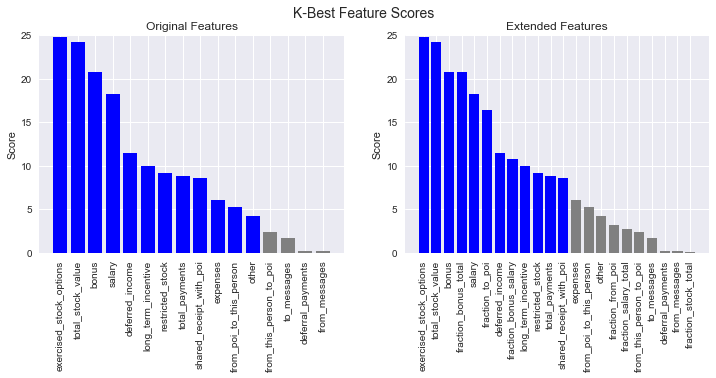

In [33]:
#Plot KBest feature scores
plt.figure(figsize=(12,4))
plt.suptitle('K-Best Feature Scores',fontsize=14)
# Left plot
plt.subplot(1,2,1)
plt.bar(range(len(k_best_features1)),k_best_features1.values(),
 align='center',color=['blue']*n+['grey']*(len(k_best_features1)-n))
plt.xticks(range(len(k_best_features1)),k_best_features1.keys(),rotation='vertical')
plt.title('Original Features')
plt.ylabel('Score')
plt.ylim(0,25)
# Right plot
plt.subplot(1,2,2)
plt.bar(range(len(k_best_features2)),k_best_features2.values(),
 align='center',color=['blue']*n+['grey']*(len(k_best_features2)-n))
plt.xticks(range(len(k_best_features2)),k_best_features2.keys(),rotation='vertical')
plt.title('Extended Features')
plt.ylabel('Score')
plt.ylim(0,25)
plt.show()

Feature scaleing

Feature scaling is used when the data would be scewed (less normaly distrobuted) when investigating. An example using salery which is in millions to emails sent which will be in hundreds. Scaling will allow the classifiers to run better and produce a more accurate asnwer.

The scaling was done using SKlearn's standardscale function.


In [35]:
# Fit Decision Tree to unscaled features and get feature importances
clf1=DecisionTreeClassifier()
clf1=clf1.fit(features2,labels2)
feature_importances1=zip(extended_features_list[1:],clf1.feature_importances_)
important_features1=OrderedDict(sorted(feature_importances1,key=lambda x: x[1],reverse=True))

# Scale features
scaler=StandardScaler(copy=True)
scaled_features=scaler.fit_transform(features2)

# Fit Decision Tree to scaled features and get feature importances
clf2=DecisionTreeClassifier()
clf2=clf2.fit(scaled_features,labels2)
feature_importances2=zip(extended_features_list[1:],clf2.feature_importances_)
important_features2=OrderedDict(sorted(feature_importances2,key=lambda x: x[1],reverse=True))

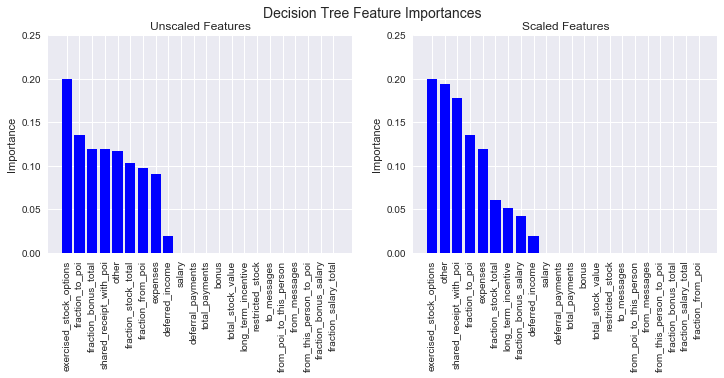

In [36]:
#Plot Decision Tree feature importances
plt.figure(figsize=(12,4))
plt.suptitle('Decision Tree Feature Importances',fontsize=14)
# Left plot
plt.subplot(1,2,1)
plt.bar(range(len(important_features1)),important_features1.values(),align='center',color=['blue'])
plt.xticks(range(len(important_features1)),important_features1.keys(),rotation='vertical')
plt.title('Unscaled Features')
plt.ylabel('Importance')
plt.ylim(0,0.25)
# Right plot
plt.subplot(1,2,2)
plt.bar(range(len(important_features2)),important_features2.values(),align='center',color=['blue'])
plt.xticks(range(len(important_features2)),important_features2.keys(),rotation='vertical')
plt.title('Scaled Features')
plt.ylabel('Importance')
plt.ylim(0,0.25)
plt.show()

Classifiers

I will run a number of CLassifers to deturmin which scores higest ready for tuning later in project.

Scoreing to choose best classifer at this step will be based on F1 score. F1 score is defnied as

"The F1 score is the harmonic mean of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall)."

Definition from https://en.wikipedia.org/wiki/F1_score

Accuracy is the ratio of individuals correctly classified as a POI to the total number of individuals.
Precision is the ratio of individuals correctly classified as a POI to the total number of individuals classified as a
POI.
Recall is the ratio of individuals correctly classified as a POI to the total number of individuals that were actually
a POI.







In [38]:
def classify(clf):
    test_classifier(clf,my_dataset,extended_features_list)

In [39]:
#GaussianNB
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
test_classifier(clf,my_dataset,extended_features_list)


GaussianNB(priors=None)
	Accuracy: 0.82487	Precision: 0.30755	Recall: 0.25050	F1: 0.27611	F2: 0.26015
	Total predictions: 15000	True positives:  501	False positives: 1128	False negatives: 1499	True negatives: 11872



In [40]:
#Random Forest Classifier (Unscaled)
pipeline=Pipeline([('kbest',SelectKBest()),
                   ('clf',RandomForestClassifier())])
clf=pipeline.fit(features2,labels2)
classify(clf)

Pipeline(steps=[('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x0000000009EF3F98>)), ('clf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])
	Accuracy: 0.85587	Precision: 0.39925	Recall: 0.16050	F1: 0.22896	F2: 0.18230
	Total predictions: 15000	True positives:  321	False positives:  483	False negatives: 1679	True negatives: 12517



In [41]:
#K Neighbors Classifier (Unscaled)
pipeline=Pipeline([('kbest',SelectKBest()),
                 ('clf',KNeighborsClassifier())])
clf=pipeline.fit(features2,labels2)
classify(clf)

Pipeline(steps=[('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x0000000009EF3F98>)), ('clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])
	Accuracy: 0.88327	Precision: 0.66985	Recall: 0.24550	F1: 0.35931	F2: 0.28112
	Total predictions: 15000	True positives:  491	False positives:  242	False negatives: 1509	True negatives: 12758



In [42]:
#K Neighbors Classifier (Scaled)
pipeline=Pipeline([('scaler',StandardScaler()),
                 ('kbest',SelectKBest()),
                 ('clf',KNeighborsClassifier())])
clf=pipeline.fit(features2,labels2)
classify(clf)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x0000000009EF3F98>)), ('clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'))])
	Accuracy: 0.84927	Precision: 0.24952	Recall: 0.06500	F1: 0.10313	F2: 0.07628
	Total predictions: 15000	True positives:  130	False positives:  391	False negatives: 1870	True negatives: 12609



In [43]:
#Support Vector Classifier (Scaled)
pipeline=Pipeline([('scaler',StandardScaler()),
                 ('kbest',SelectKBest()),
                 ('clf',SVC(kernel="linear"))])
clf=pipeline.fit(features2,labels2)
classify(clf)

Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x0000000009EF3F98>)), ('clf', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])
	Accuracy: 0.86440	Precision: 0.47416	Recall: 0.15600	F1: 0.23476	F2: 0.18018
	Total predictions: 15000	True positives:  312	False positives:  346	False negatives: 1688	True negatives: 12654



In [44]:
#AdaBoost Classifier (Unscaled)
pipeline=Pipeline([('kbest',SelectKBest()),
                   ('clf',AdaBoostClassifier())])
clf=pipeline.fit(features2,labels2)
classify(clf)

Pipeline(steps=[('kbest', SelectKBest(k=10, score_func=<function f_classif at 0x0000000009EF3F98>)), ('clf', AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None))])
	Accuracy: 0.82500	Precision: 0.31163	Recall: 0.25850	F1: 0.28259	F2: 0.26763
	Total predictions: 15000	True positives:  517	False positives: 1142	False negatives: 1483	True negatives: 11858



Tuning

I will tune the parameters of the best performing classifiers using GridSearchCV Cross Validation to try to
achieve better than 0.3 for both precision and recall. Since is the harmonic mean of the precision and recall,
we will use this metric to guide our tuning.

reserch on f1 for teh 0.3 score

In [47]:
#DecisionTree Classifier
pipeline=Pipeline([('scaler',StandardScaler()),
                   ('kbest',SelectKBest()),
                   ('clf',DecisionTreeClassifier())])
param_grid=([{'kbest__k':[6,12,18],
              'clf__max_depth':[None,1,2],
              'clf__min_samples_split':[10,20,30],
              'clf__class_weight':[None,'balanced']}])
clf=GridSearchCV(pipeline,param_grid,scoring='f1').fit(features2,labels2).best_estimator_
#perf_labels,perf_metrics=classify(clf)
classify(clf)

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Pipeline(steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('kbest', SelectKBest(k=12, score_func=<function f_classif at 0x0000000009EF3F98>)), ('clf', DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=10, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))])
	Accuracy: 0.80140	Precision: 0.33721	Recall: 0.50700	F1: 0.40503	F2: 0.46062
	Total predictions: 15000	True positives: 1014	False positives: 1993	False negatives:  986	True negatives: 11007



In [48]:
#AdaBoost Classifier
pipeline=Pipeline([('kbest',SelectKBest()),
                   ('clf',AdaBoostClassifier())])
param_grid=([{'kbest__k':[6,12,18],
              'clf__base_estimator':[DecisionTreeClassifier(class_weight='balanced',max_depth=1),
                                     DecisionTreeClassifier(class_weight='balanced',max_depth=2)],
              'clf__n_estimators':[25,50,75],
              'clf__learning_rate':[0.01,0.1,1.0],
              'clf__algorithm':['SAMME']}])
clf=GridSearchCV(pipeline,param_grid,scoring='f1').fit(features2,labels2).best_estimator_
#perf_labels,perf_metrics=classify(clf)
classify(clf)

Pipeline(steps=[('kbest', SelectKBest(k=12, score_func=<function f_classif at 0x0000000009EF3F98>)), ('clf', AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
      ...om_state=None, splitter='best'),
          learning_rate=0.01, n_estimators=50, random_state=None))])
	Accuracy: 0.80360	Precision: 0.36006	Recall: 0.60850	F1: 0.45242	F2: 0.53471
	Total predictions: 15000	True positives: 1217	False positives: 2163	False negatives:  783	True negatives: 10837



In [49]:
#Store this classifier
CLF=clf
final_kbest=CLF.named_steps['kbest']
final_clf=CLF.named_steps['clf']
#final_perf_labels=perf_labels
#final_perf_metrics=perf_metrics

In [50]:
CLF.named_steps['clf']

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.01, n_estimators=50, random_state=None)

In [51]:
#K Neighbors Classifier (Unscaled)
pipeline=Pipeline([('kbest',SelectKBest()),
                   ('clf',KNeighborsClassifier())])
param_grid=([{'kbest__k':[6,12,18],
              'clf__n_neighbors':[3,4,5]}])
clf=GridSearchCV(pipeline,param_grid,scoring='f1').fit(features2,labels2).best_estimator_
#perf_labels,perf_metrics=classify(clf)
classify(clf)

Pipeline(steps=[('kbest', SelectKBest(k=12, score_func=<function f_classif at 0x0000000009EF3F98>)), ('clf', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=2,
           weights='uniform'))])
	Accuracy: 0.87427	Precision: 0.55327	Recall: 0.29600	F1: 0.38567	F2: 0.32635
	Total predictions: 15000	True positives:  592	False positives:  478	False negatives: 1408	True negatives: 12522



Result

In [53]:
The best scoreing algorithm was the AdaBoost Classifier using SelectKBest to select features.
Paramters printed two cells below.


In [54]:
#Select K-Best
n=final_kbest.k
k_best=final_kbest
k_best.fit(features2,labels2)
feature_scores=zip(extended_features_list[1:],k_best.scores_)
k_best_features=OrderedDict(sorted(feature_scores,key=lambda x: x[1]))
#AdaBoost Classifier
clf=final_clf
clf=clf.fit(k_best.transform(features2),labels2)
feature_importances=zip(extended_features_list[1:],clf.feature_importances_)
important_features=OrderedDict(sorted(feature_importances,key=lambda x: x[1]))

In [55]:
#Output Classifier Parameters
print 'Best performing classifier: '+str(final_clf)[:str(final_clf).find('(')]+'\n'
for k in CLF.named_steps.values():
    print k


Best performing classifier: AdaBoostClassifier

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.01, n_estimators=50, random_state=None)
SelectKBest(k=12, score_func=<function f_classif at 0x0000000009EF3F98>)


In [57]:
#Output Feature Scores and Feature Importances
print '\nFeature Scores:\n'
print('{:30}{:15}{:15}'.format('Feature:','Score:','Importance:'))
for k in extended_features_list[1:]:
    print('{:29}{:8.4f}{:14.4f}'.format(k,k_best_features[k],(important_features[k] if (k in important_features) else 0.0)))   


Feature Scores:

Feature:                      Score:         Importance:    
salary                        18.2897        0.0707
deferral_payments              0.2246        0.0000
total_payments                 8.7728        0.0000
bonus                         20.7923        0.0040
deferred_income               11.4585        0.0666
total_stock_value             24.1829        0.0656
expenses                       6.0942        0.0000
exercised_stock_options       24.8151        0.1037
other                          4.1875        0.0949
long_term_incentive            9.9222        0.0000
restricted_stock               9.2128        0.0000
to_messages                    1.6463        0.5944
from_poi_to_this_person        5.2434        0.0000
from_messages                  0.1697        0.0000
from_this_person_to_poi        2.3826        0.0000
shared_receipt_with_poi        8.5894        0.0000
fraction_bonus_salary         10.7836        0.0000
fraction_bonus_total          20.7156

In [58]:
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.
dump_classifier_and_data(CLF,my_dataset,extended_features_list)

Conclusion

The aim of this project was to build a machine learning classifier to identify Enron employeers who may of commited fraud based on the data set provided.

Through out this notebook i have:
-looked at the data set
-cleaned the data set
-looked for an delt with any outliers in the data
-lookd at the data and created some new features 
- Run a nuber of diffrent classifers to see their diffrent "score"
- During the above step the data was scaled if the classifer needed so.
- Once i had run multipe clissifers i choose the top 3 to then Tune.
- I then tuned the top 3 with gridsearcCV to find the best paramemters to feed into the classifier.
- I then looked at the F1 score for the Tuned top 3 to pick a "winner".

My chosen classifier is adiboost with the follow parameters:

AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'),
          learning_rate=0.01, n_estimators=50, random_state=None)
SelectKBest(k=12, score_func=<function f_classif at 0x0000000009EF3F98>)

The final scores for my classifer is:

Accuracy: 0.80360	Precision: 0.36006	Recall: 0.60850	F1: 0.45242	F2: 0.53471

Which means that:

80.36% of all the individuals were correctly classified as a person of interest.
Of all the individuals classified as a person of interest, 36% of these classifications were correct.
Of all the actual persons of interest, 60.90% of these were correctly classified.



